In [245]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf
from keras import optimizers
from keras.models import Sequential
from keras.layers import LSTM, Dropout, Dense, TimeDistributed, Input, Activation, concatenate
from keras.callbacks import History
from keras.models import Model

# The values have around 15 decimals, so for more clarity in reading we're increasing the number of displayed values
pd.set_option('display.float_format', '{:.15f}'.format)

# 1. Importing the data

In [11]:
sensor_and_loc_file = '../data/Processed/sensor_data_and_location_1.csv'

In [21]:
df_sensor_and_loc = pd.read_csv(sensor_and_data_file, index_col=0)
df_sensor_and_loc

,ax,ay,az,gx,gy,gz,mx,my,mz,a_total,g_total,m_total,lat,long
11:05:09:00,0.917251600000000,0.223266600000000,9.617767000000001,-0.033401490000000,0.057952880000000,0.003723144500000,51.450348499999997,-49.124908499999997,-263.400264999999990,9.663986782827630,0.066992967089706,272.838632163932175,44.434918000000003,26.047605999999998
11:05:09:01,0.799926760000000,0.194534300000000,9.680023000000000,-0.052566530000000,0.046249390000000,-0.004806518600000,52.200316999999998,-48.599243000000001,-263.549800000000005,9.714966376461094,0.070180829096450,273.029772360293236,44.434918000000003,26.047606078717038
11:05:09:02,0.658676150000000,0.101165770000000,9.876343000000000,-0.057891846000000,0.024932861000000,-0.003738403300000,52.349853500000002,-49.124908499999997,-263.175200000000018,9.898799919043093,0.063143400685792,272.791737487752755,44.434918000000003,26.047606157434078
11:05:09:03,0.594024660000000,0.072433470000000,10.029572000000000,-0.036590576000000,0.002563476600000,0.007980347000000,52.499389999999998,-49.650573999999999,-262.800599999999974,10.047408939992856,0.037538348425722,272.553702615212273,44.434917999999989,26.047606236151118
11:05:09:04,0.634735100000000,0.041305542000000,10.098998999999999,-0.012084961000000,-0.029388428000000,0.015441894500000,50.999450000000003,-50.025176999999999,-262.274935000000028,10.119010603659476,0.035329563943415,271.834052942028165,44.434917999999989,26.047606314868165
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11:06:35:06,-1.591556747826087,0.416365249130435,7.214611565217392,-0.005165090000000,-1.256576500000000,0.186408996500000,38.226670923076931,-13.672989769230769,-263.861201538461614,7.504824145161314,1.381125341560086,266.978598048934145,44.434937499964576,26.047601814784940
11:06:35:07,-1.516087439130435,0.389092485652174,7.487654326086957,-0.056919088333333,-1.251960716666667,0.178330739250000,38.030536769230771,-13.569171307692306,-263.884324615384628,7.761037291203633,1.387844997391878,266.969167982637657,44.434937499964576,26.047601736067875
11:06:35:08,-1.440618130434783,0.361819722173913,7.760697086956522,-0.108673086666667,-1.247344933333333,0.170252482000000,37.834402615384612,-13.465352846153843,-263.907447692307699,8.017250437245952,1.394564653223671,266.959737916341112,44.434937499964569,26.047601657350807
11:06:35:09,-1.365148821739130,0.334546958695652,8.033739847826087,-0.160427085000000,-1.242729150000000,0.162174224750000,37.638268461538459,-13.361534384615384,-263.930570769230826,8.273463583288271,1.401284309055463,266.950307850044624,44.434937499964569,26.047601578633738


In [310]:
data = df_sensor_and_loc.copy(deep=True)
data.reset_index(inplace=True)
data.drop(['index'], axis=1, inplace=True)
data.head()

,ax,ay,az,gx,gy,gz,mx,my,mz,a_total,g_total,m_total,lat,long
0,0.917251600000000,0.223266600000000,9.617767000000001,-0.033401490000000,0.057952880000000,0.003723144500000,51.450348499999997,-49.124908499999997,-263.400264999999990,9.663986782827630,0.066992967089706,272.838632163932175,44.434918000000003,26.047605999999998
1,0.799926760000000,0.194534300000000,9.680023000000000,-0.052566530000000,0.046249390000000,-0.004806518600000,52.200316999999998,-48.599243000000001,-263.549800000000005,9.714966376461094,0.070180829096450,273.029772360293236,44.434918000000003,26.047606078717038
2,0.658676150000000,0.101165770000000,9.876343000000000,-0.057891846000000,0.024932861000000,-0.003738403300000,52.349853500000002,-49.124908499999997,-263.175200000000018,9.898799919043093,0.063143400685792,272.791737487752755,44.434918000000003,26.047606157434078
3,0.594024660000000,0.072433470000000,10.029572000000000,-0.036590576000000,0.002563476600000,0.007980347000000,52.499389999999998,-49.650573999999999,-262.800599999999974,10.047408939992856,0.037538348425722,272.553702615212273,44.434917999999989,26.047606236151118
4,0.634735100000000,0.041305542000000,10.098998999999999,-0.012084961000000,-0.029388428000000,0.015441894500000,50.999450000000003,-50.025176999999999,-262.274935000000028,10.119010603659476,0.035329563943415,271.834052942028165,44.434917999999989,26.047606314868165


# 2. View some info about the data

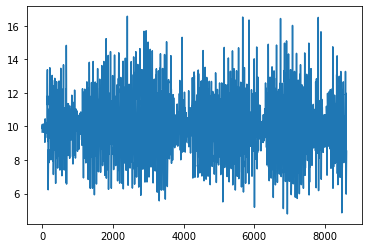

In [30]:
plt.plot(data['a_total'])

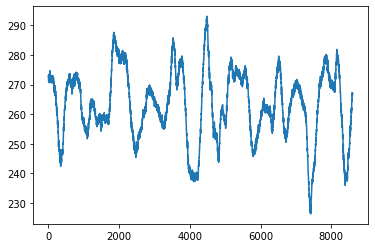

In [31]:
plt.plot(data['m_total'])

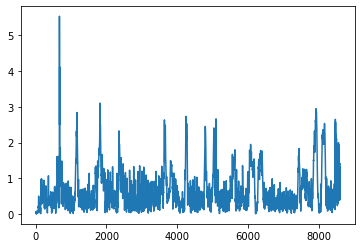

In [32]:
plt.plot(data['g_total'])

### Plot a simple Latitude and Longitude scatter plot

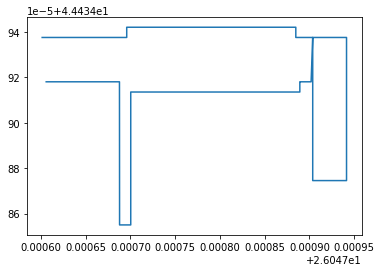

In [48]:
plt.plot(data['long'], data['lat'])

### Plot the Latitude and Longitude on the world map

In [82]:
import plotly.express as px
import pandas as pd

pos_df = pd.concat([data['lat'], data['long']], axis=1)
fig = px.scatter_geo(pos_df,lat=pos_df['lat'],lon=pos_df['long'], hover_name=pos_df.index)
fig.update_layout(title = 'World map', title_x=0.5, geo = dict(projection_scale=800000, center=dict(lat=pos_df['lat'][0], lon=pos_df['long'][0])))
fig.show()

### Plot the ground truth from xml in order to compare with the interpolated data

In [64]:
position_file = '../data/Processed/ground_truth_1.csv'
position_df = pd.read_csv(position_file, index_col=0)
position_df

,lat,long
11:05:09:00,44.434918000000003,26.047605999999998
11:05:10:60,44.434917999999307,26.047618594726657
11:05:11:60,44.434917999998618,26.047631189453320
11:05:12:40,44.434917999997921,26.047643784179972
11:05:13:20,44.434917999997225,26.047656378906638
...,...,...
11:06:30:90,44.434937499967326,26.047651878840107
11:06:31:70,44.434937499966637,26.047639284109248
11:06:32:70,44.434937499965947,26.047626689378390
11:06:33:50,44.434937499965251,26.047614094647528


In [81]:
fig = px.scatter_geo(position_df,lat=position_df['lat'],lon=position_df['long'], hover_name=position_df.index)
fig.update_layout(title = 'World map', title_x=0.5, geo = dict(projection_scale=800000, center=dict(lat=position_df['lat'][0], lon=position_df['long'][0])))
fig.show()

# 3. Creating the LSTM model

## 3.1. Scaling the data

In [96]:
sc = MinMaxScaler(feature_range=(0, 1))
data_scaled = sc.fit_transform(data)
print(data_scaled)

[[5.58110410e-01 4.07448493e-01 4.22342495e-01 ... 6.97031007e-01
  7.24015708e-01 1.32332916e-02]
 [5.47867150e-01 4.04137933e-01 4.27567093e-01 ... 6.99893004e-01
  7.24015708e-01 1.34647730e-02]
 [5.35535006e-01 3.93379933e-01 4.44042504e-01 ... 6.96328840e-01
  7.24015708e-01 1.36962543e-02]
 ...
 [3.52252276e-01 4.23412700e-01 2.66494953e-01 ... 6.09004640e-01
  9.48284431e-01 4.62962940e-04]
 [3.58841262e-01 4.20270309e-01 2.89409030e-01 ... 6.08863441e-01
  9.48284431e-01 2.31481463e-04]
 [3.65430248e-01 4.17127918e-01 3.12323107e-01 ... 6.08722242e-01
  9.48284431e-01 0.00000000e+00]]


In [101]:
print(data_scaled.shape[0], data_scaled.shape[1])

8611 14


## 3.2. Reshaping the data in order to feed it to the model

In [ ]:
# The following cell does this:

# []
# i = 0
# X = [[]]
# for j in range(30, 8611)
#     J = 30
#     X[0].append(data_scaled[30-30=0:30, 0]) --> append and array
#     J = 31
#     X[0].append(31-30=1:31, 0)
#     
# i = 1
# X = [
#       [  <-- 12 of those
#        [5.5811, 5.4786, .., 5.1232  <--- 30 (backcandles) of those], [], ..., [] <--- 8581 of those
#       ],
#      [
#        [5.5811, 5.4786, .., 5.1232], [], ..., []
#      ]
#    ]   ---> 
# for j in range(30, 8611)
#     X[0].append(data_scaled[30-30:30, 0])

In [276]:
X = []
backcandles=50 # number of last values to look into

for i in range(12): #number of attributes columns
    X.append([])
    for j in range(backcandles, data_scaled.shape[0]):
        X[i].append(data_scaled[j-backcandles:j, i])
        
# move axis from 0 to position 2
X = np.moveaxis(X, [0], [2])

# We need shape (8581, 30, 12) = (rows, val of past attributes, columns) for LSTM training
X.shape

(8561, 50, 12)

In [301]:
# Transform X and the targets (lat and long columns) into arrays so the axis can be moved and the data 
# to be used in the LSTM model
X, yi = np.array(X), np.array(data_scaled[backcandles:, [-2,-1]])

# Move the axis for yi, so instead of (8581, 2) we'll have (8581, 1, 2)
# I HAVE MODIFIED THIS:
# y = np.reshape(yi,(len(yi), 1, 2))
# y = np.reshape(yi,(len(yi), 2))

print('X Shape: ',X.shape)
print('y shape: ', y.shape)
data_scaled[backcandles:, [-2,-1]]

X Shape:  (8561, 50, 12)
y shape:  (8561, 2)


array([[7.24015706e-01, 2.48073613e-02],
       [7.24015706e-01, 2.50388427e-02],
       [7.24015706e-01, 2.52703241e-02],
       ...,
       [9.48284431e-01, 4.62962940e-04],
       [9.48284431e-01, 2.31481463e-04],
       [9.48284431e-01, 0.00000000e+00]])

## 3.3. Split the data into train, test and validation sets

In [278]:
splitlimit_test = int(len(X) * 0.7)
splitlimit_val = int(len(X) * 0.9)

print(splitlimit_test, splitlimit_val)
X_train, X_test, X_val = X[:splitlimit_test], X[splitlimit_test:splitlimit_val], X[splitlimit_val:]
y_train, y_test, y_val = y[:splitlimit_test], y[splitlimit_test:splitlimit_val], y[splitlimit_val:]
print(X_train.shape)
print(X_test.shape)
print(X_val.shape)
print(y_train.shape)
print(y_test.shape)
print(y_val.shape)

5992 7704
(5992, 50, 12)
(1712, 50, 12)
(857, 50, 12)
(5992, 2)
(1712, 2)
(857, 2)


In [306]:
attributes_cols = 12
batch_size=40
epochs=20

lstm_input = Input(shape=(backcandles, attributes_cols), name='lstm_input')
inputs = LSTM(150, name='first_layer')(lstm_input)
inputs = Dense(2, name='dense_layer')(inputs)
output = Activation('relu', name='output')(inputs)
model = Model(inputs=lstm_input, outputs=output)
adam = optimizers.Adam()
model.compile(optimizer=adam, loss='mse')
model.fit(x=X_train, y=y_train, batch_size=batch_size, epochs=epochs, shuffle=True, validation_split=0.1)

Epoch 1/20
135/135 [==============================] - 7s 44ms/step - loss: 0.0792 - val_loss: 0.1560
Epoch 2/20
135/135 [==============================] - 6s 42ms/step - loss: 0.0511 - val_loss: 0.1560
Epoch 3/20
135/135 [==============================] - 6s 41ms/step - loss: 0.0367 - val_loss: 0.1642
Epoch 4/20
135/135 [==============================] - 6s 41ms/step - loss: 0.0241 - val_loss: 0.1667
Epoch 5/20
135/135 [==============================] - 6s 41ms/step - loss: 0.0188 - val_loss: 0.1760
Epoch 6/20
135/135 [==============================] - 6s 43ms/step - loss: 0.0244 - val_loss: 0.0905
Epoch 7/20
135/135 [==============================] - 6s 43ms/step - loss: 0.0169 - val_loss: 0.1185
Epoch 8/20
135/135 [==============================] - 6s 43ms/step - loss: 0.0150 - val_loss: 0.1538
Epoch 9/20
135/135 [==============================] - 6s 42ms/step - loss: 0.0093 - val_loss: 0.1521
Epoch 10/20
135/135 [==============================] - 6s 43ms/step - loss: 0.0153 - val_lo

In [307]:
y_pred = model.predict(X_test)
for i in range(10):
    print(y_pred[i], y_test[i])

54/54 [==============================] - 1s 12ms/step
[0.6697763 0.4728665] [0.9482846  0.85490197]
[0.67008054 0.46654072] [0.9482846  0.85479303]
[0.6686305 0.4623038] [0.9482846 0.8546841]
[0.66735613 0.458769  ] [0.9482846  0.85457517]
[0.66594386 0.45689324] [0.9482846  0.85446624]
[0.6634389  0.45717183] [0.9482846 0.8543573]
[0.6620679  0.45675495] [0.9482846  0.85424837]
[0.6612414  0.45689777] [0.9482846  0.85413944]
[0.6616763 0.4511871] [0.9482846  0.85403051]
[0.6631565 0.441642 ] [0.9482846  0.85392157]


array([0.9482846 , 0.9482846 , 0.9482846 , ..., 0.94828448, 0.94828448,
       0.94828448])

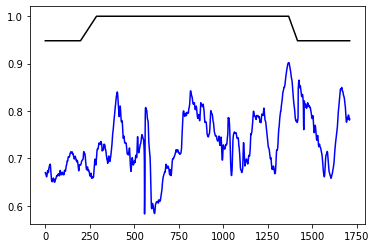

In [314]:
plt.plot(y_test[:, 0], color='black', label='Test')
plt.plot(y_pred[:, 0], color='blue', label='Pred')
y_test[:, 0]

In [296]:
# data = {'c1': [2, 3, 4], 'c2': [3, 5, 6], 'c3': [3, 5, 6]}
# df = pd.DataFrame(data)
# df
# print(df.iloc[:, [-2, -1]])

   c2  c3
0   3   3
1   5   5
2   6   6
